In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Dataset from https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [168]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis = 1)

In [169]:
df.head()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [170]:
df.columns = dataset_cols

In [171]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [172]:
df["functional"] = (df["functional"] == "Yes").astype(int)

In [173]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [174]:
df = df[df["hour"] == 12]

In [175]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,12,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,12,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,12,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,12,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,12,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [176]:
 df = df.drop(["hour"], axis = 1)

In [177]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


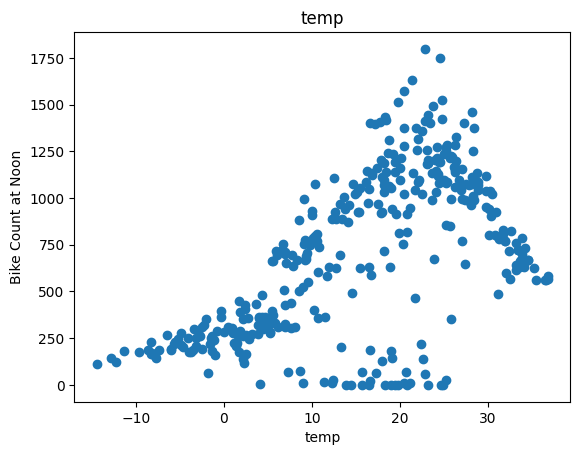

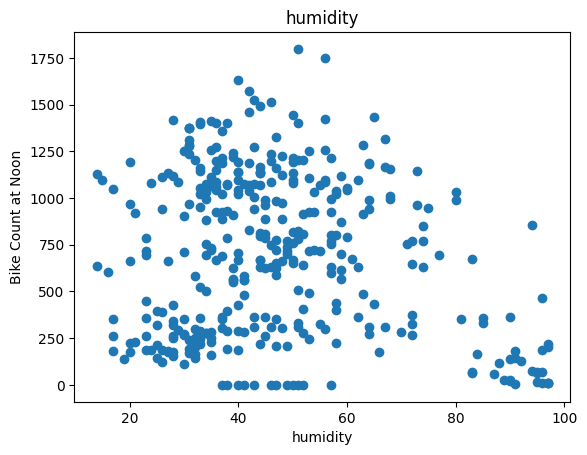

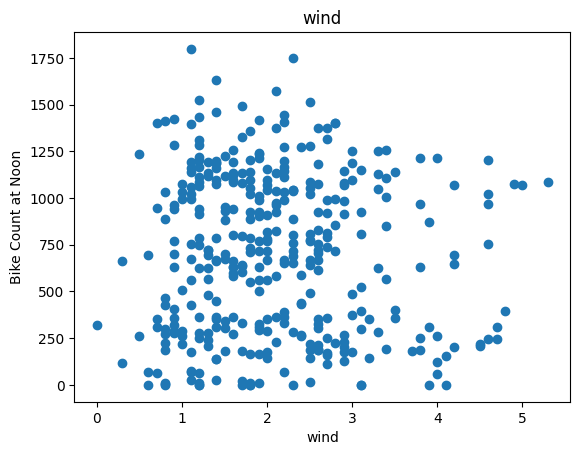

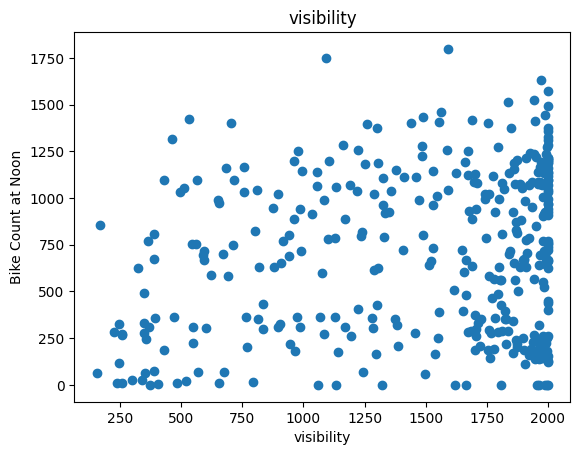

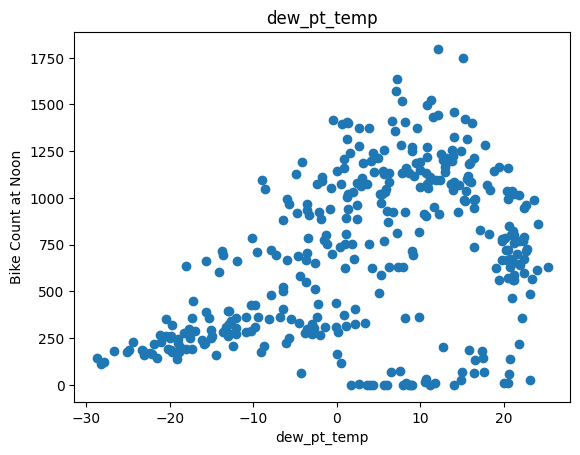

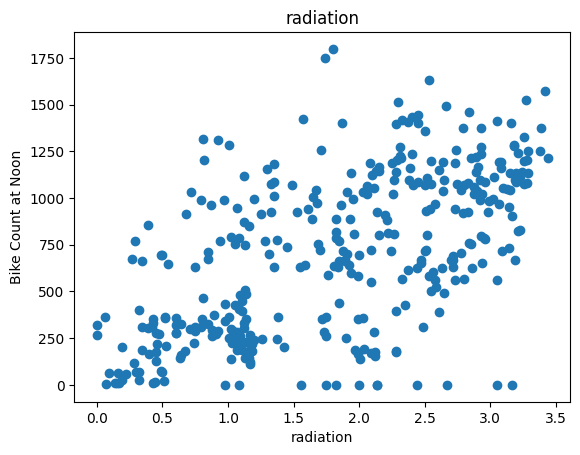

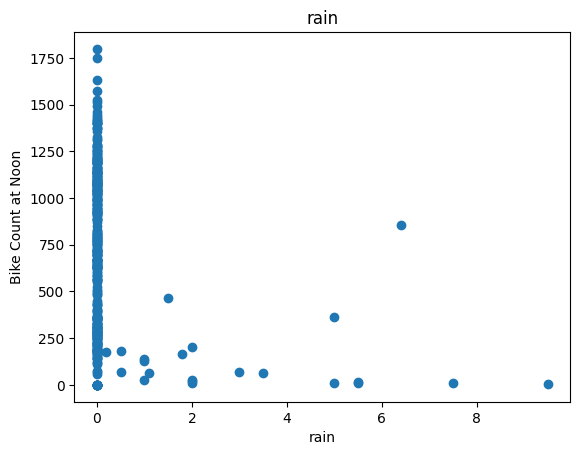

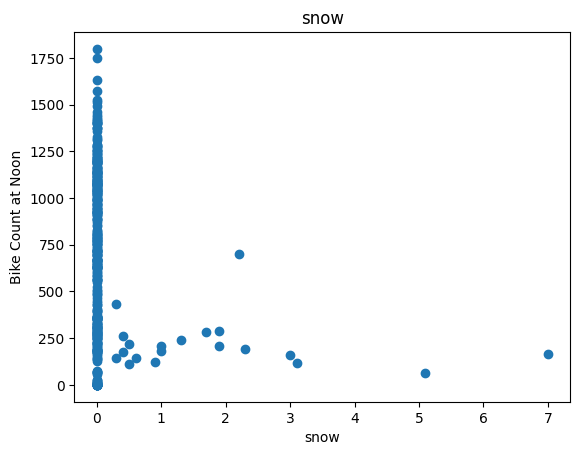

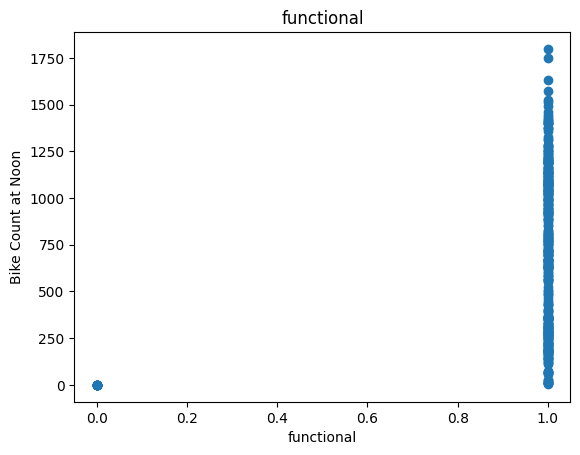

In [178]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [179]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

In [180]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/Valid/Test Dataset

In [181]:
train, valid, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [182]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if (len(x_labels) == 1):
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values
  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))
  return data, X, y

In [183]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", ["temp"])
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", ["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", ["temp"])

In [184]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [185]:
temp_reg.score(X_test_temp, y_test_temp)

0.22194172033363668

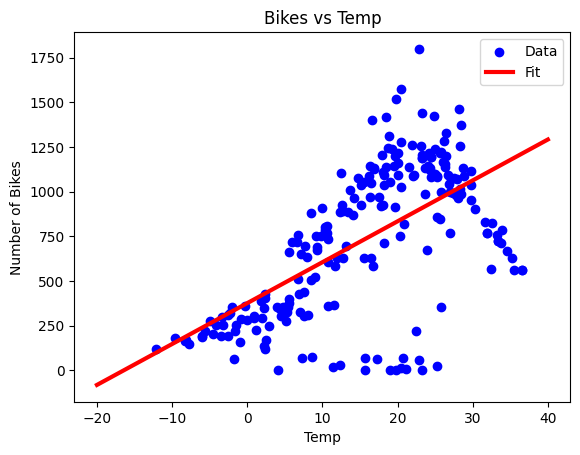

In [186]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [187]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [188]:
train, valid, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", df.columns[1:])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [189]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [190]:
all_reg.score(X_test_all, y_test_all)

0.41606571516456003

# Regression with Neural Net

In [191]:
def plot_loss(history):
  plt.plot(history.history["loss"], label = "loss ")
  plt.plot(history.history["val_loss"], label = "val_oss")
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.legend()
  plt.grid(True)
  plt.show()

In [192]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [193]:
temp_nn_model = tf.keras.models.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units = 1)
])

In [194]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [195]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs = 1000,
    validation_data = (X_valid_temp, y_valid_temp)
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 671276.6250 - val_loss: 605059.4375
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 694138.6250 - val_loss: 603781.2500
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 706678.0625 - val_loss: 602494.3750
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 684588.5625 - val_loss: 601230.8750
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 703157.8125 - val_loss: 599958.8750
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 702827.1250 - val_loss: 598707.0625
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 658786.1250 - val_loss: 597463.0000
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 666957.8750 - val_loss: 596202.3750
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 670281.7500 - val_loss: 594950.7500
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 663931.9375 - val_loss: 593725.1250
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

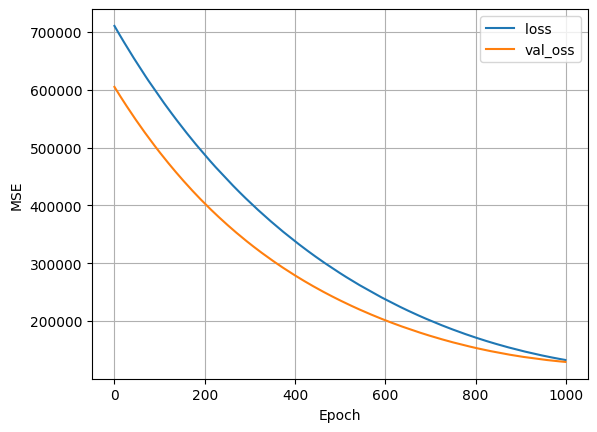

In [196]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


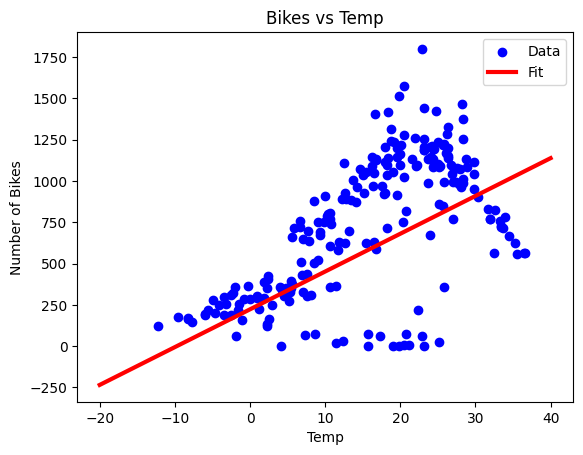

In [197]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [198]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.models.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units = 32, activation = "relu"),
    tf.keras.layers.Dense(units = 32, activation = "relu"),
    tf.keras.layers.Dense(units = 32, activation = "relu"),
    tf.keras.layers.Dense(units = 1)
])

In [199]:
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mean_squared_error")

In [200]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    epochs = 100,
    validation_data = (X_valid_temp, y_valid_temp),
    verbose = 0,
)

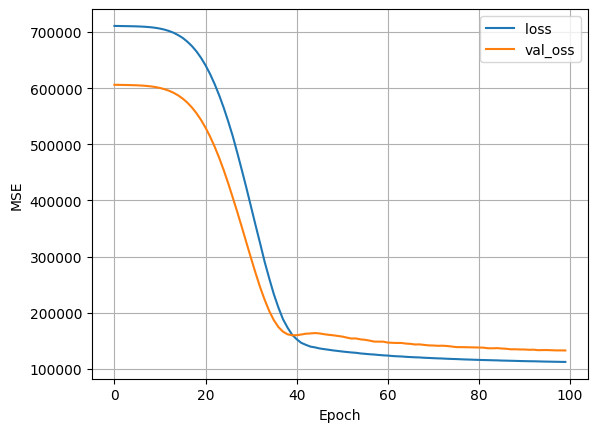

In [201]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


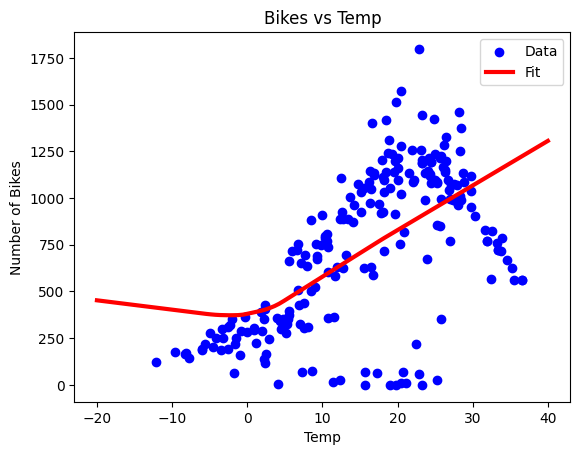

In [202]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

In [203]:
all_normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = -1)
all_normalizer.adapt(X_train_all)

In [204]:
nn_model = tf.keras.models.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(units = 32, activation = "relu"),
    tf.keras.layers.Dense(units = 32, activation = "relu"),
    tf.keras.layers.Dense(units = 1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mean_squared_error")

In [205]:
history = nn_model.fit(
    X_train_all, y_train_all,
    epochs = 100,
    validation_data = (X_valid_all, y_valid_all),
    verbose = 0,
)

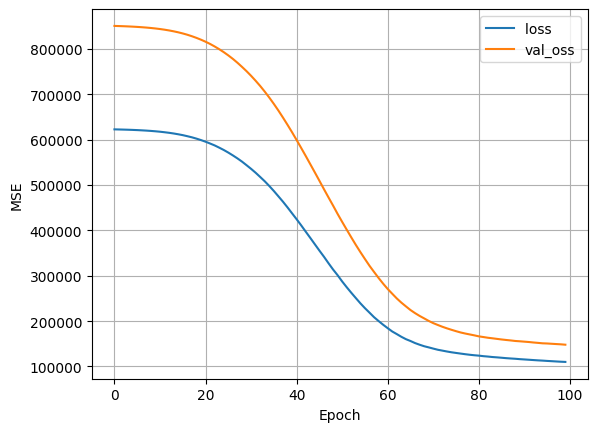

In [206]:
plot_loss(history)

In [207]:
# Calculate the MSE for LR and NN
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [208]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [209]:
MSE(y_pred_lr, y_test_all)

np.float64(105703.22167408487)

In [210]:
MSE(y_pred_nn, y_test_all)

np.float64(133494.02140922213)

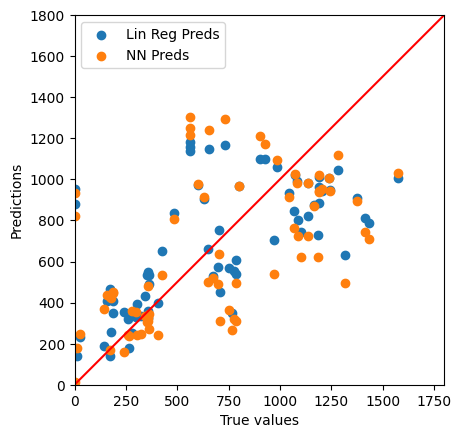

In [211]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_lr, label = "Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label = "NN Preds")
plt.xlabel("True values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, color = "red")